In [1]:
import numpy as np
from cmaes import CMA
import matplotlib.pyplot as plt
import itertools

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="Single-shot")
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 198kB
Dimensions:  (dim_0: 2744)
Coordinates:
    x0       (dim_0) float64 22kB 4.8e-08 8.4e-08 1.16e-07 ... 4.64e-07 4.96e-07
    x1       (dim_0) float64 22kB 7.37e+09 7.37e+09 ... 7.42e+09 7.42e+09
    x2       (dim_0) float64 22kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 22kB 0.5121 0.5113 0.5073 ... 0.6654 0.6754 0.6877
    y1       (dim_0) float64 22kB 0.5138 0.5134 0.5043 ... 0.691 0.7051 0.7134
    y2       (dim_0) float64 22kB 0.5136 0.5111 0.5088 ... 0.742 0.7585 0.7749
    y3       (dim_0) float64 22kB 0.509 0.5095 0.5088 ... 0.5631 0.5624 0.5748
    y4       (dim_0) float64 22kB 0.5 0.5044 0.5 0.5 ... 0.5884 0.6033 0.6135
    y5       (dim_0) float64 22kB 0.5 0.5001 0.5 0.5 ... 0.5572 0.5739 0.5796
Attributes:
    tuid:                             20241127-010313-461-3332cc
    name:                             Single-shot readout vs. pulse duration,...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [4]:
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data

QND_pi_fidelity = dataset.y5.data

freq_reshape = []
amplitude_reshape = []
average_fidelity_reshape = []
QND_pi_fidelity_reshape = []

# Count occurrences
unique_duration_values, counts = np.unique(duration, return_counts=True)

for i in unique_duration_values:
    indices = np.where(duration == i)
    freq_reshape.append(frequency[indices])
    amplitude_reshape.append(amplitude[indices])
    average_fidelity_reshape.append(average_fidelity[indices])
    QND_pi_fidelity_reshape.append(QND_pi_fidelity[indices])

In [5]:
#For now just work with longest duration data:
duration = unique_duration_values[-1]
frequency_test = freq_reshape[-1]
amplitude_test = amplitude_reshape[-1]
average_fidelity_test = average_fidelity_reshape[-1]

In [6]:
def plotSingleFidelity(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'
    vmin, vmax = 0.5, 1  # Set fidelity range for consistent scaling

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Fidelity")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    plt.show()

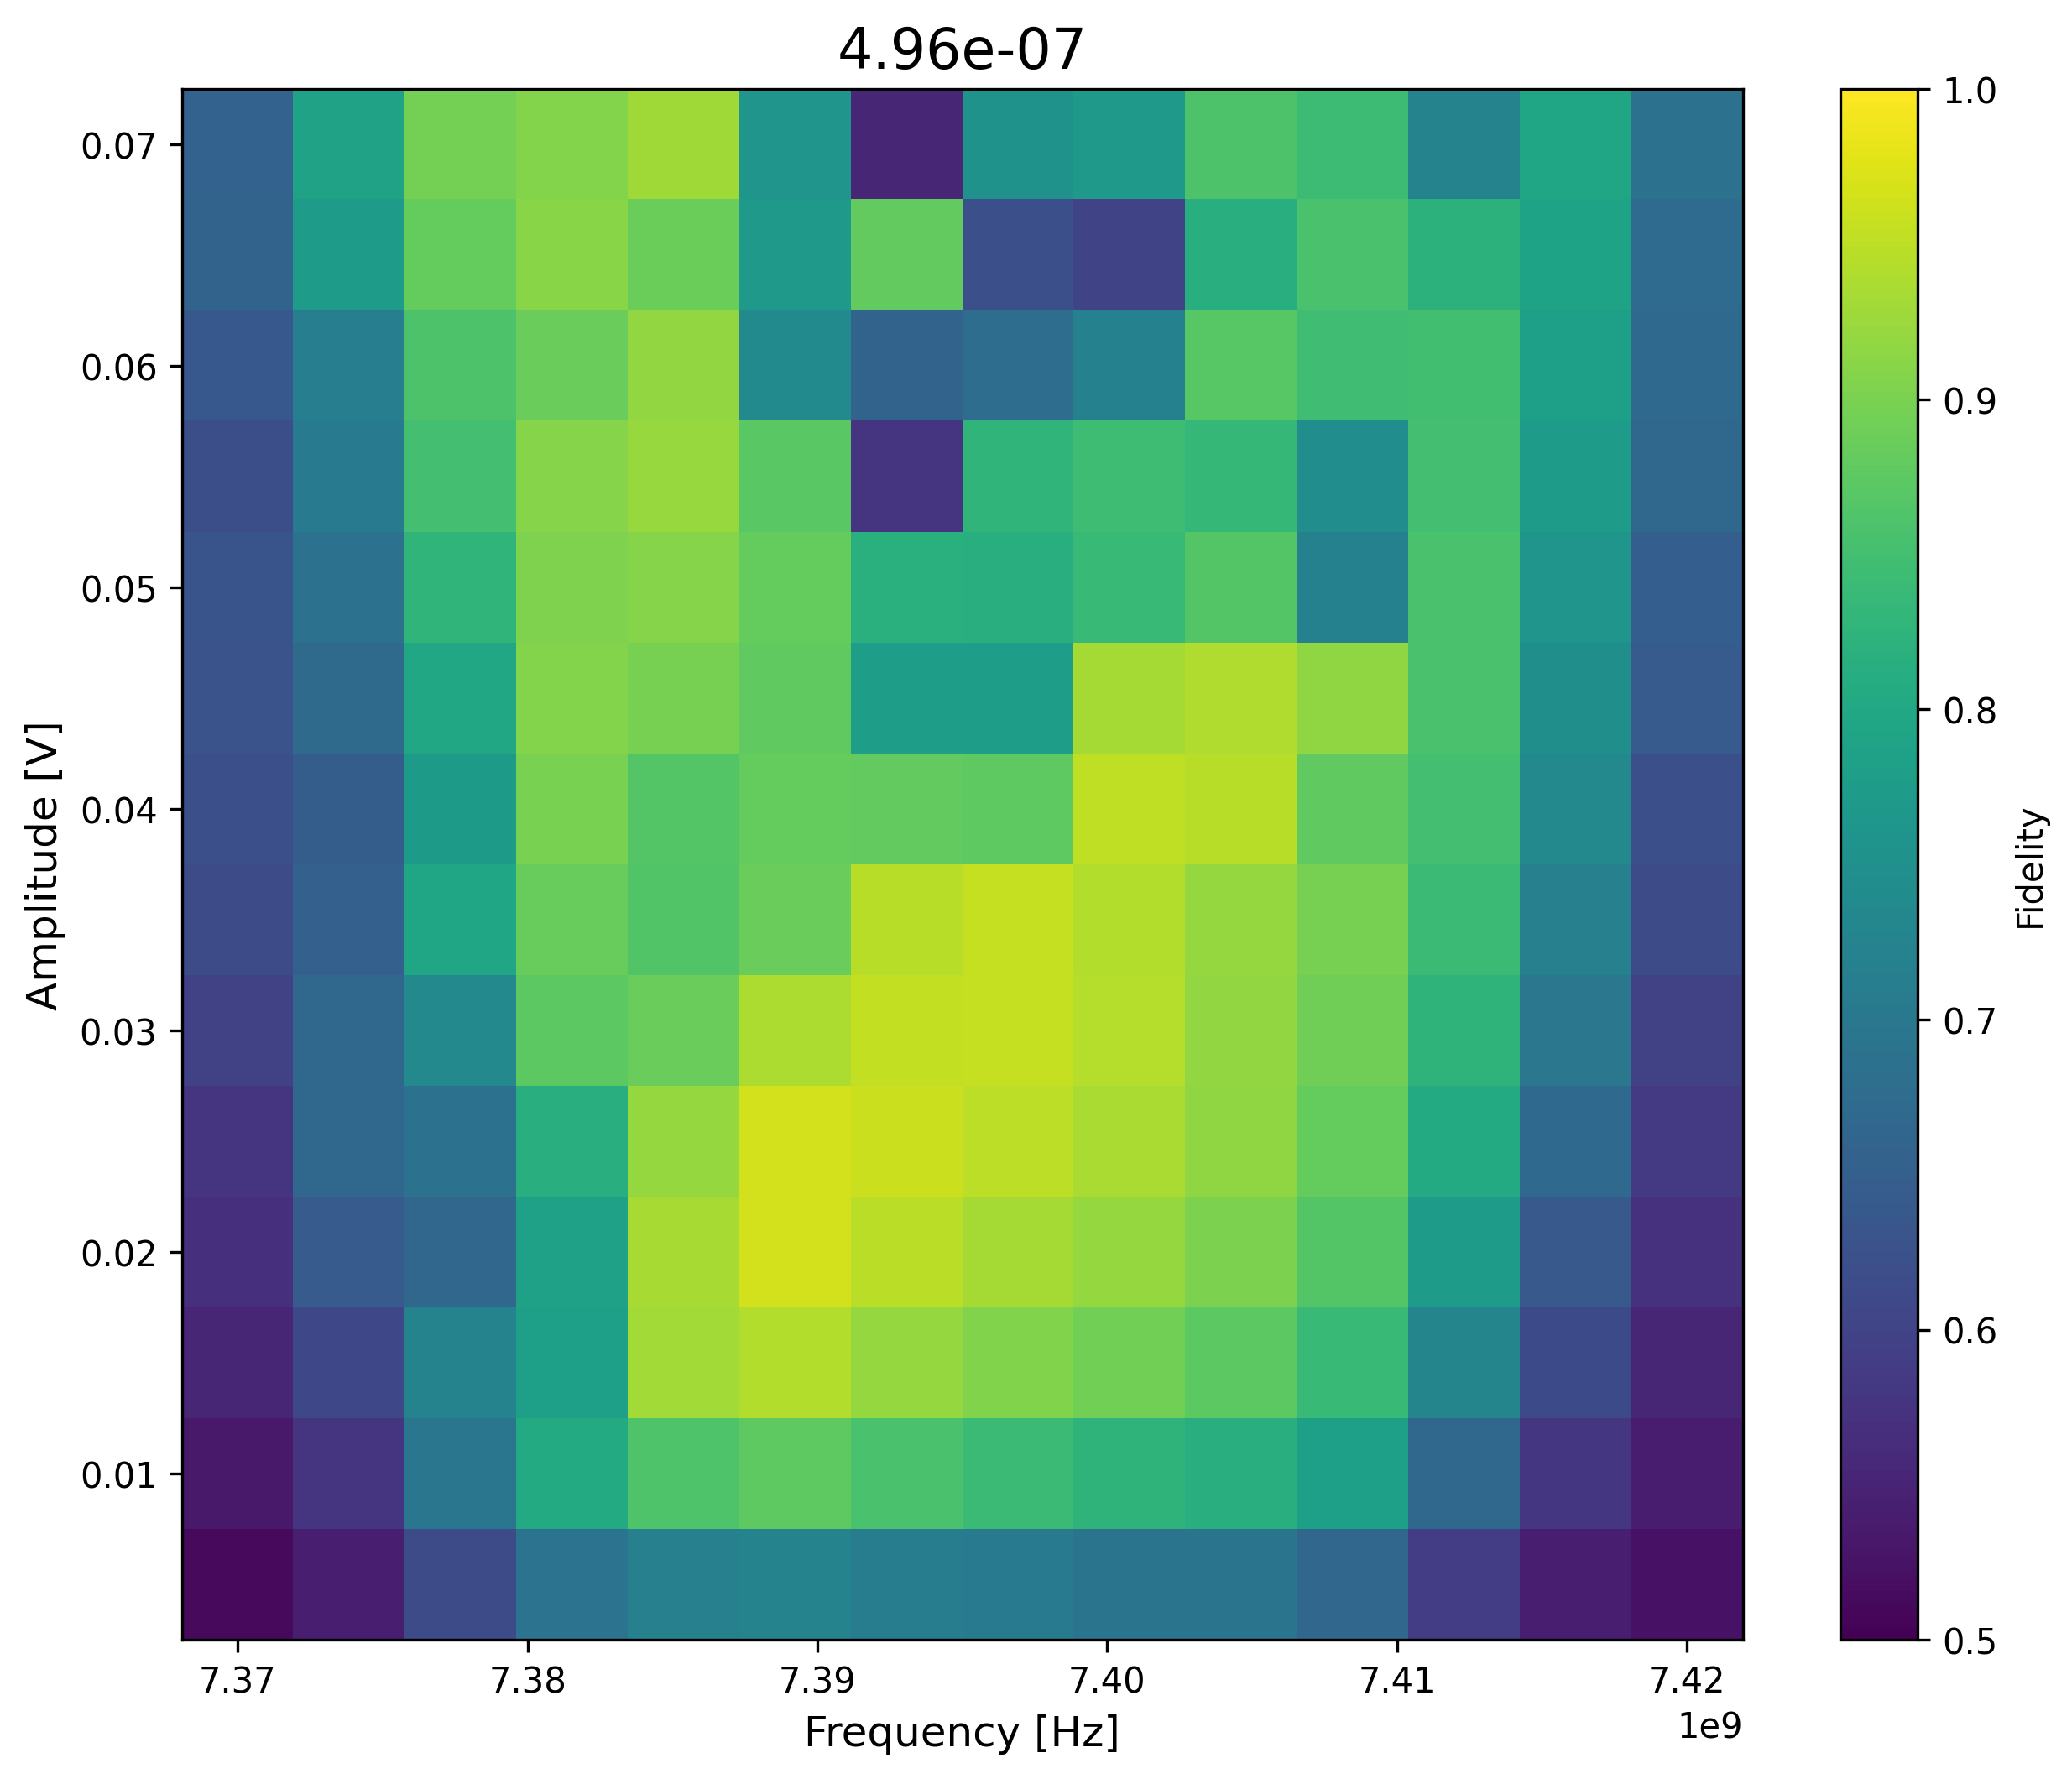

In [7]:
plotSingleFidelity(frequency_test,amplitude_test,average_fidelity_test,str(duration))

In [8]:
def fidelityEstimate(point,frequency,amplitude,fidelity):
    # Get unique values of frequency and amplitude
    unique_freq = np.unique(frequency)
    unique_ampl = np.unique(amplitude)
    
    # Get the closest 2 unique frequencies and amplitudes
    dFreq = np.abs(unique_freq - point[0])
    dAmpl = np.abs(unique_ampl - point[1])
    
    freqArgs = np.argsort(dFreq)[:2]
    amplArgs = np.argsort(dAmpl)[:2]
    
    x_coor = unique_freq[freqArgs]
    y_coor = unique_ampl[amplArgs]
    
    # Sort the coordinates
    sortedX = np.sort(x_coor)
    sortedY = np.sort(y_coor)
    
    # Calculate differences
    dx = np.diff(sortedX)
    dy = np.diff(sortedY)
    
    fidelities = []
    
    for i in itertools.product(sortedX,sortedY):
        temp1 = np.where(i[0] == frequency)
        temp2 = np.where(i[1] == amplitude)
        arg = np.intersect1d(temp1,temp2)
        fidelities.append(fidelity[arg])
    
    fidelities = np.array(fidelities)
    
    # Reshape fidelities into a 2x2 grid for interpolation
    fidelity_matrix = fidelities.reshape((2, 2))
    # print(fidelity_matrix)
    
    # Bilinear interpolation formula
    result = (fidelity_matrix[0, 0] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[1, 0] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[0, 1] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) +
              fidelity_matrix[1, 1] * (point[0] - sortedX[0]) * (point[1] - sortedY[0])) / (dx * dy)

    return result

61


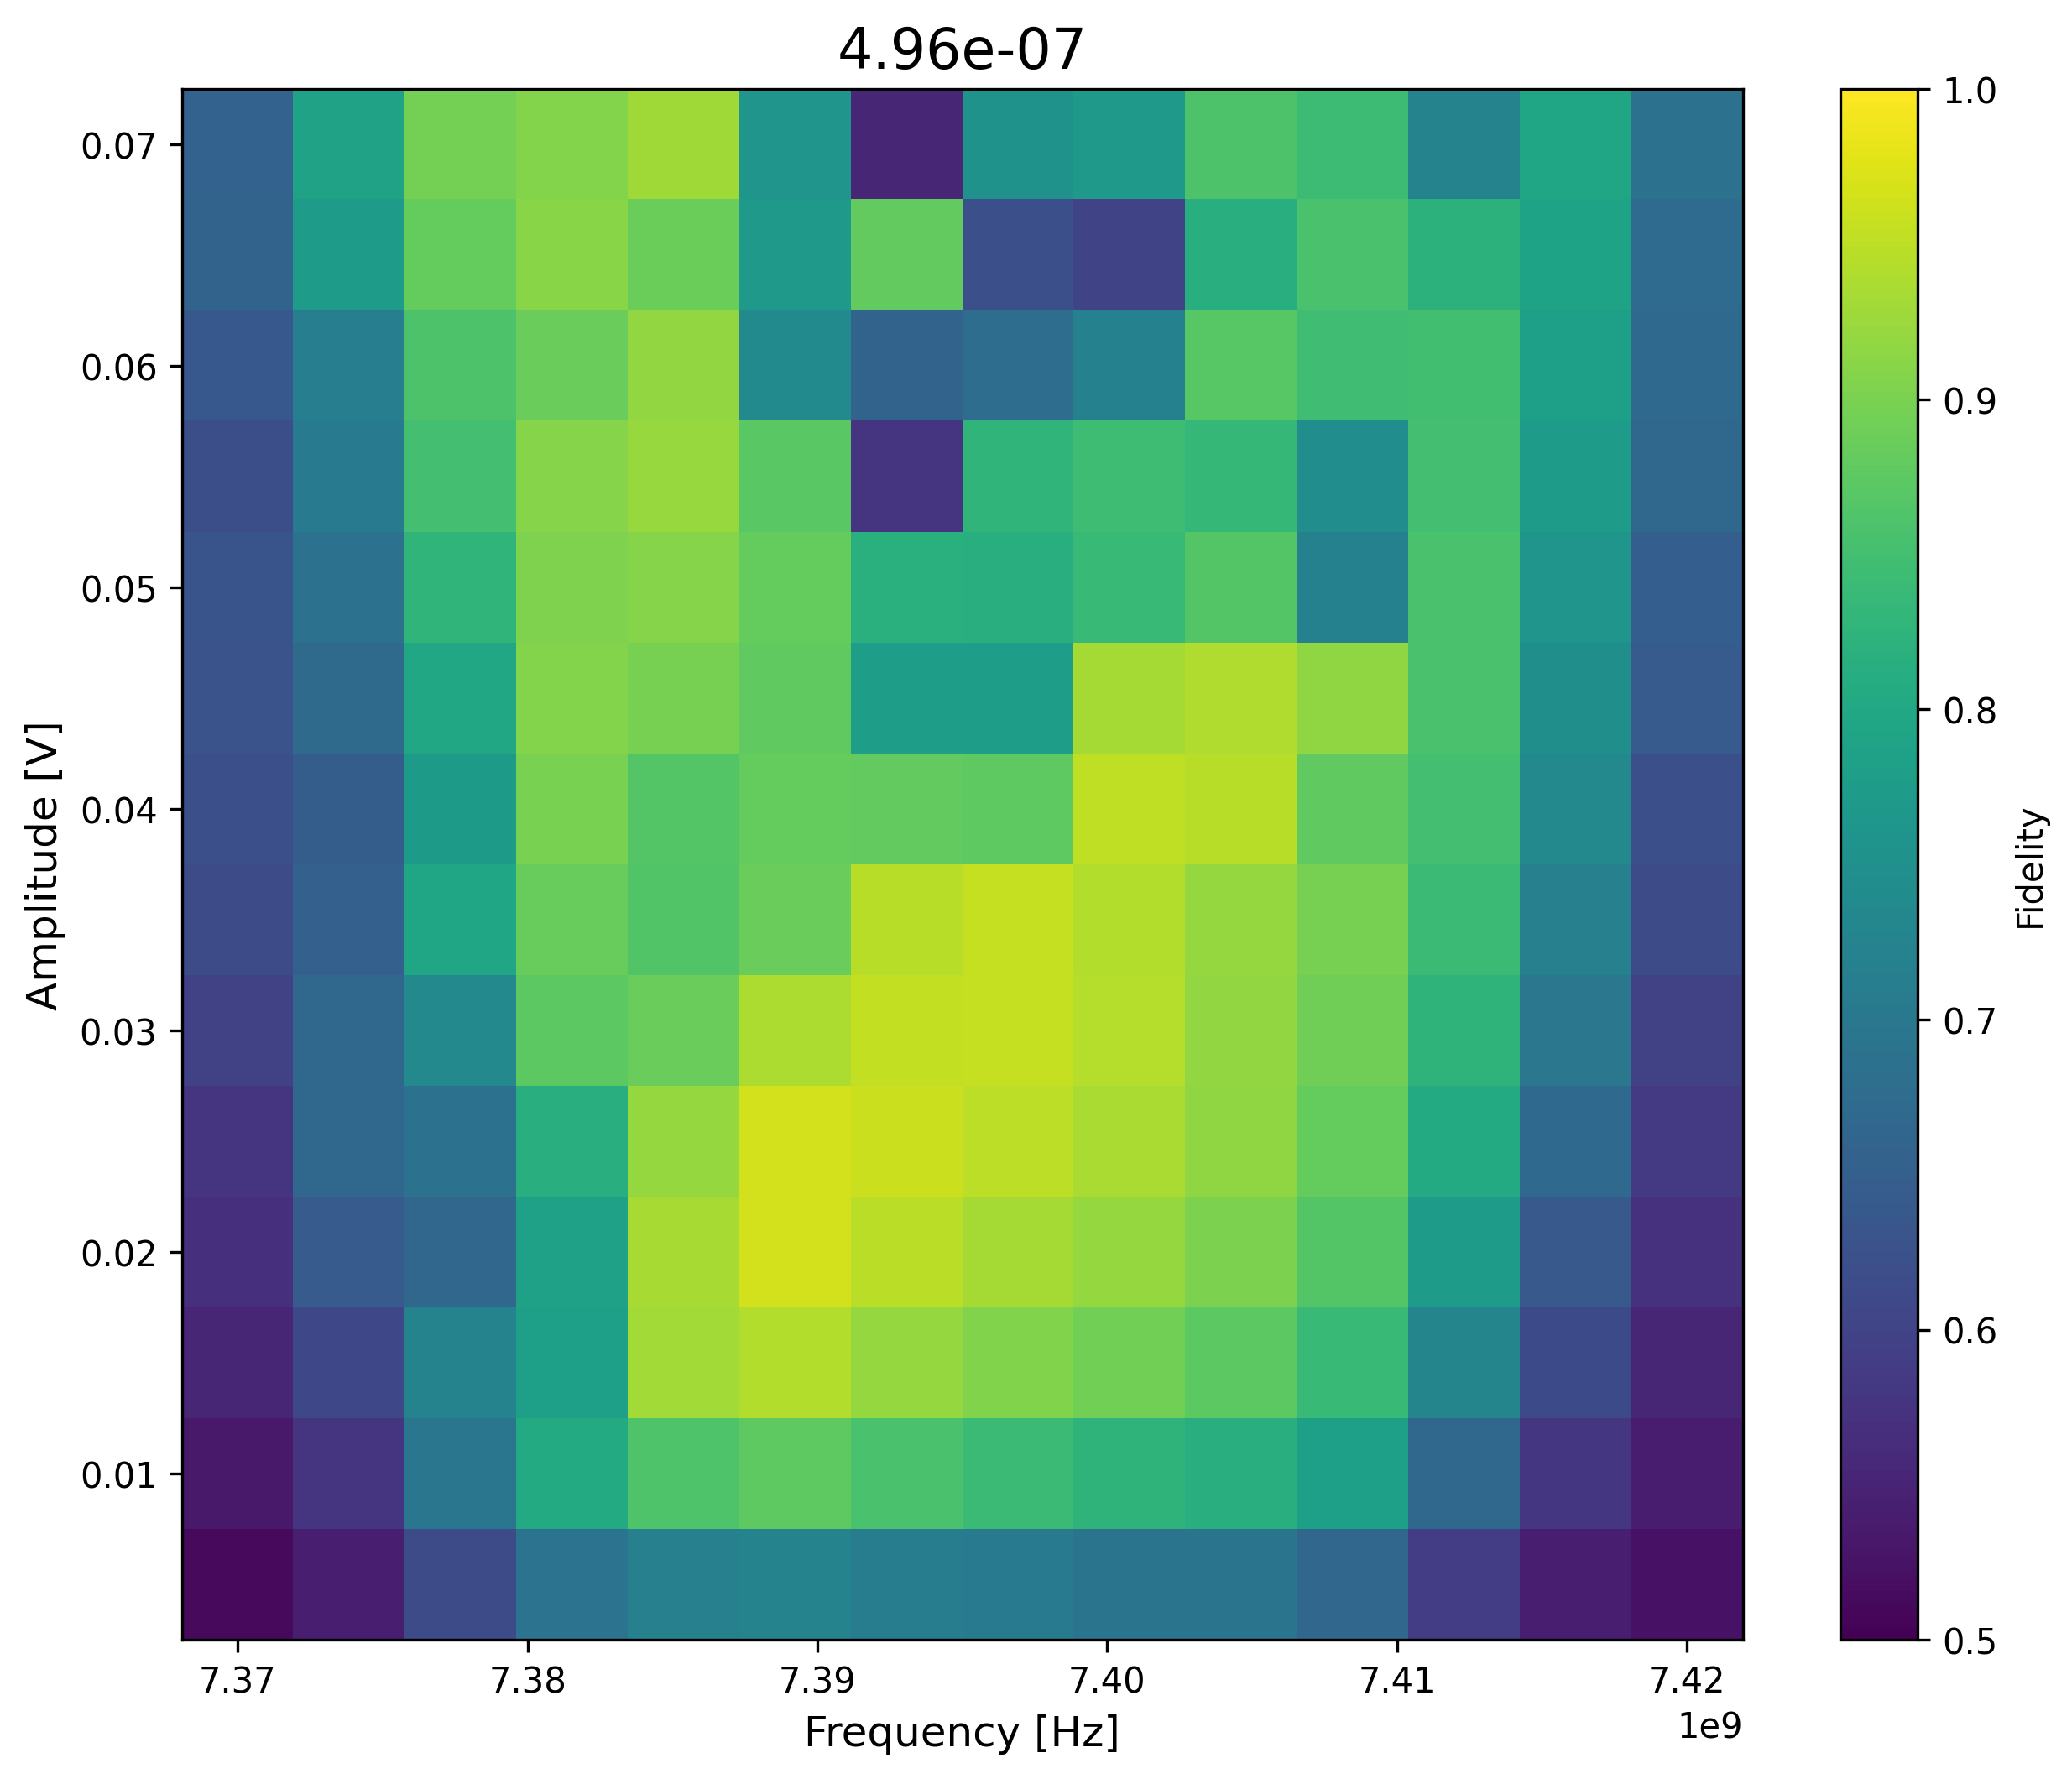

In [9]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

61


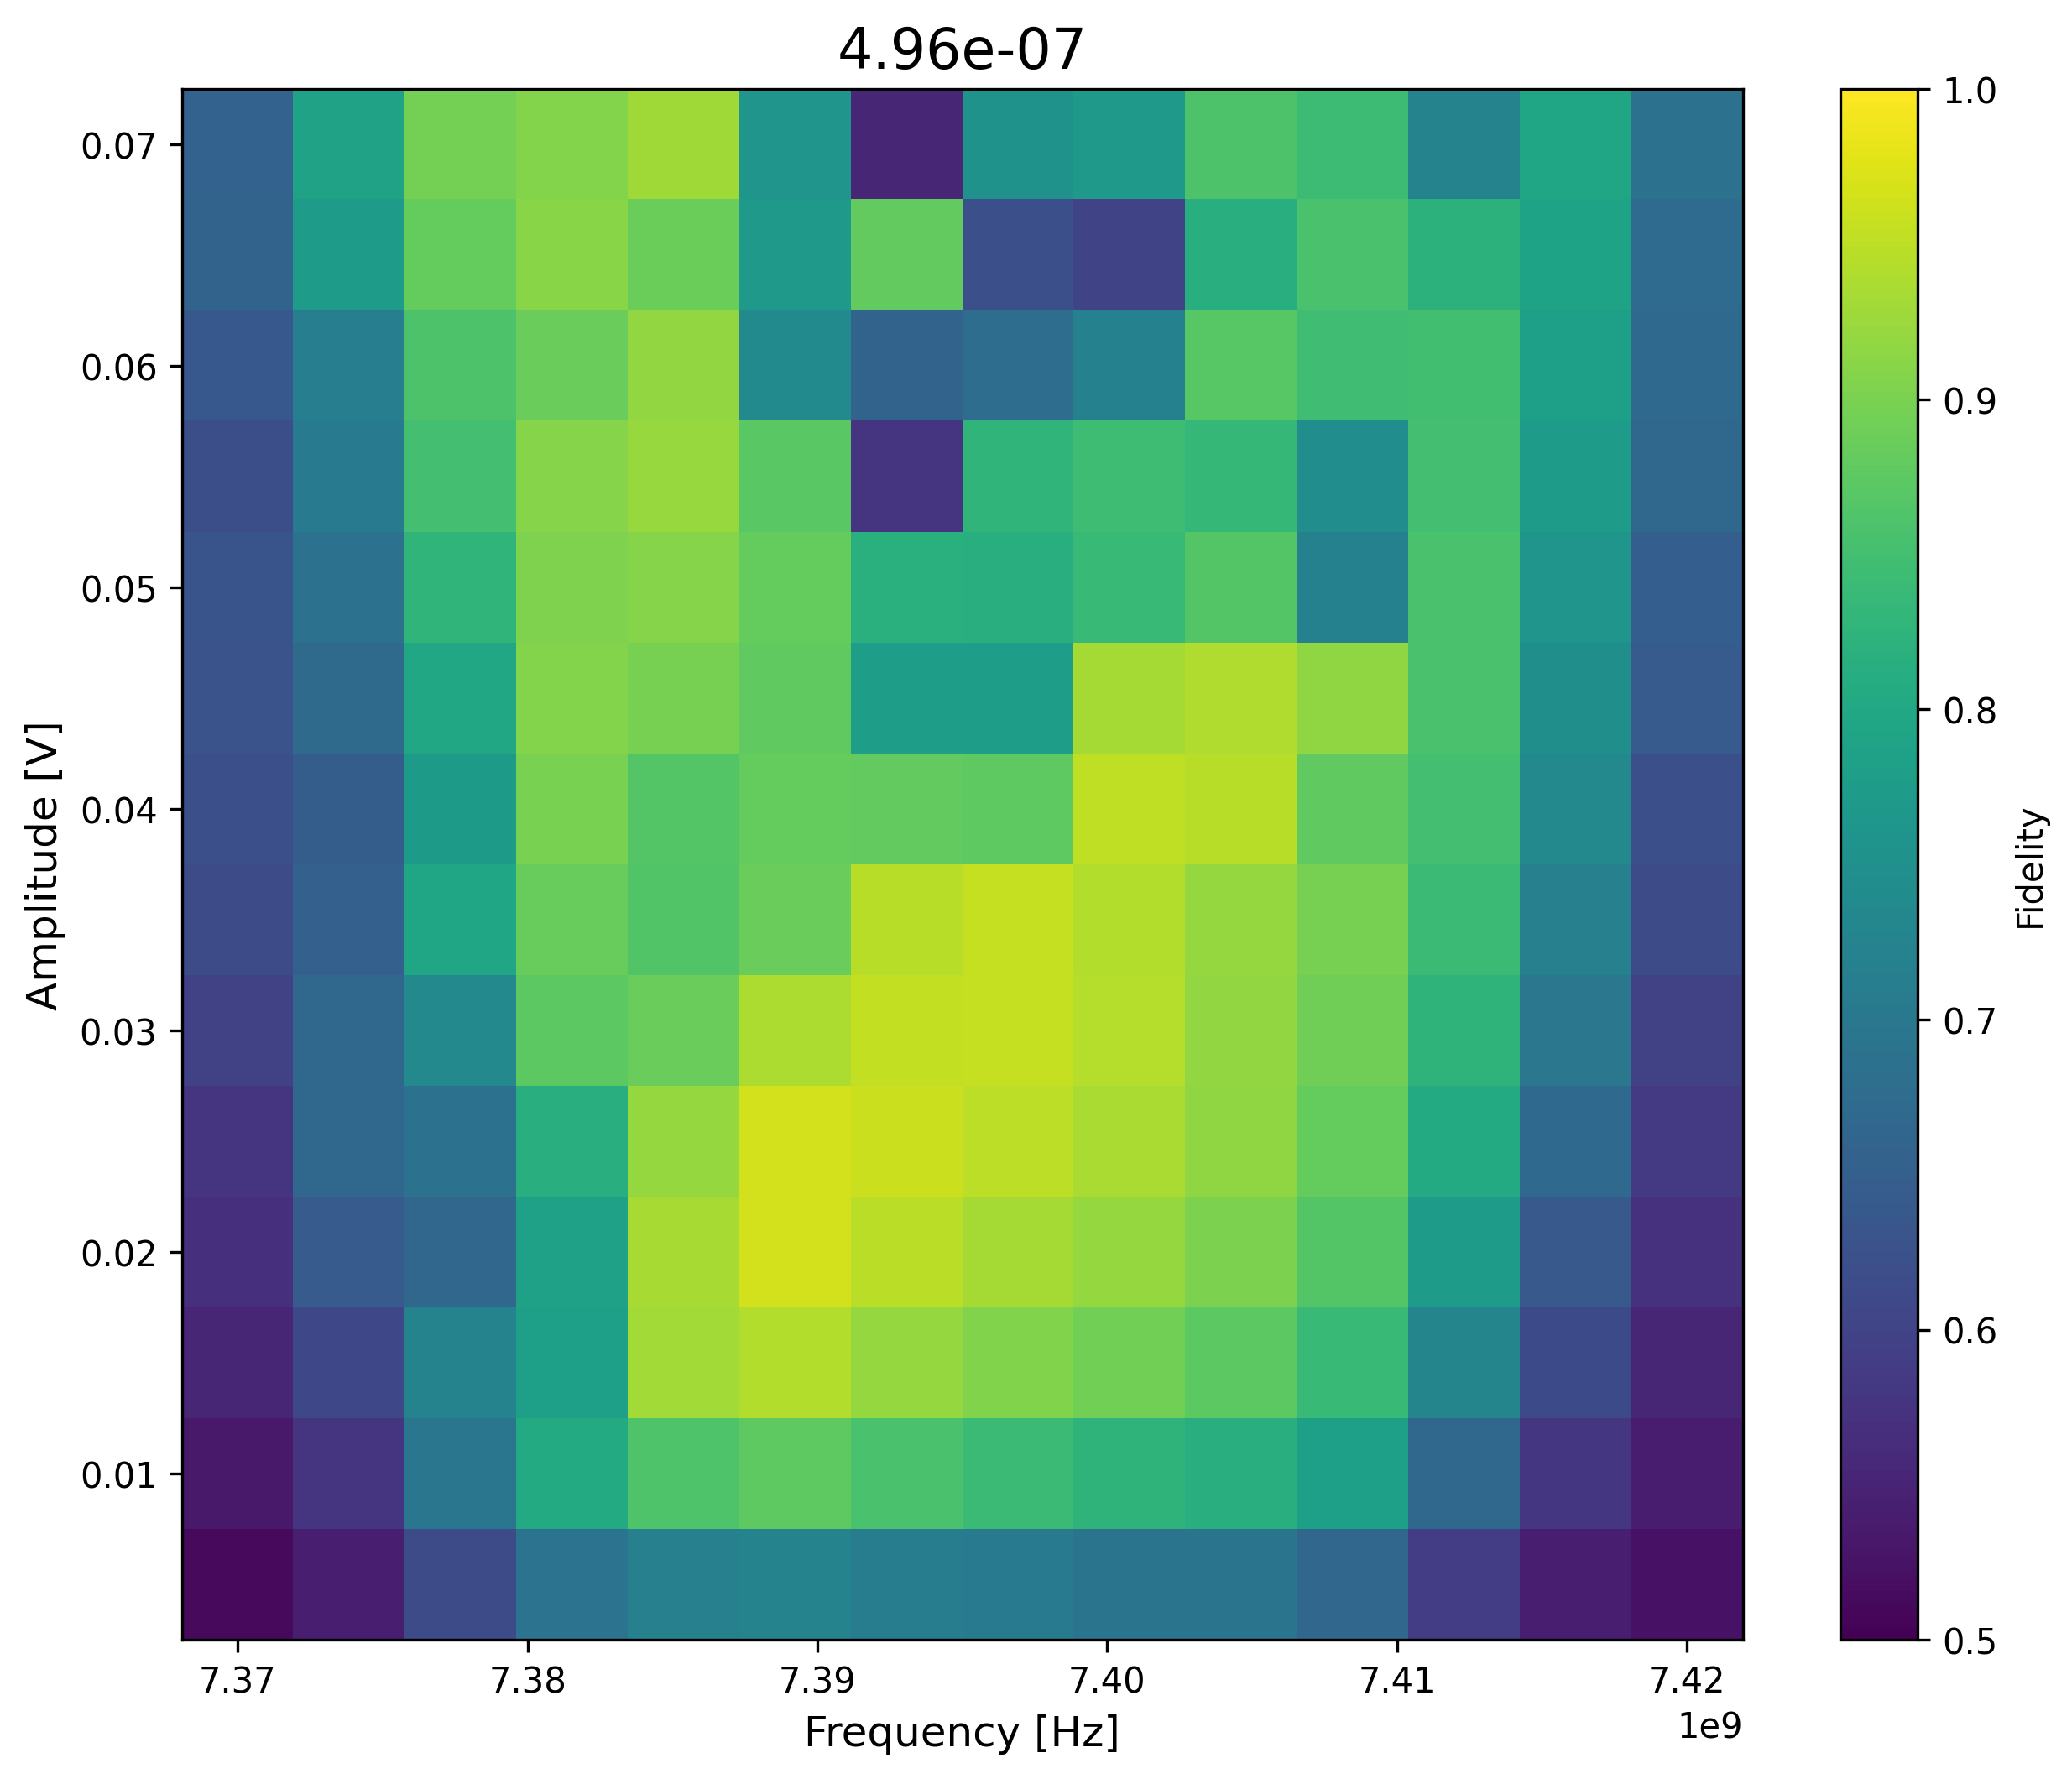

In [10]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

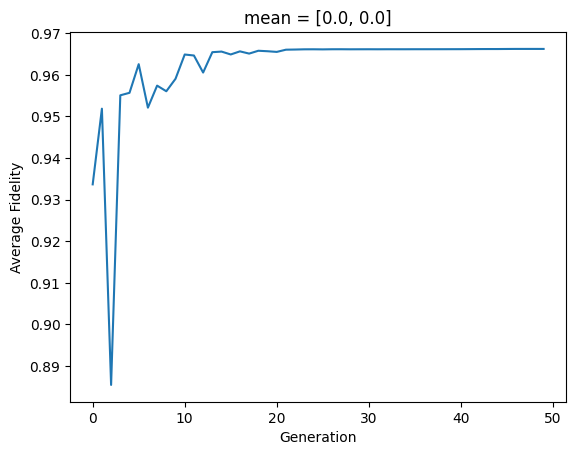

In [25]:
def objective(point,frequency,amplitude,fidelity):
    F = fidelityEstimate(point, frequency, amplitude, fidelity)
    return np.log(1-F)

popsize = 10
sigma = 0.25 #1/4 of the domain 

boundX = [0,1]
boundY = [0,1]
bounds = np.array([boundX,boundY])

mean = np.array([0.0,0.0])

optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize,bounds=bounds)

minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq-minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl-minAmpl

Ngen = 50

maxFidelity = np.zeros(Ngen)
coordinate = np.zeros((Ngen,2))
meanFidelity = np.zeros(Ngen)

for generation in range(Ngen):
    solutions = []
    fid = 0
    mean_hat = np.copy(optimizer.mean)
    mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
    mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl

    meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]

    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        
        x_hat = np.copy(x)
        x_hat[0] = x_hat[0]*deltaFreq+minFreq
        x_hat[1] = x_hat[1]*deltaAmpl+minAmpl

        value = objective(x_hat,frequency_test, amplitude_test,average_fidelity_test)
        tmpFidelity = fidelityEstimate(x_hat,frequency_test,amplitude_test,average_fidelity_test)

        if tmpFidelity > fid:
            maxFidelity[generation] = tmpFidelity[0]
            coordinate[generation,:] = x_hat
            
            fid = tmpFidelity
        
        solutions.append((x,value))
        # print("after ", optimizer._sigma)

        # print(f"{generation=} {value=} {x_hat=}")
    # print(solutions[0])
    optimizer.tell(solutions)


plt.plot(range(Ngen),maxFidelity)
plt.xlabel("Generation")
plt.ylabel("Average Fidelity")
plt.title(f"mean = {mean.tolist() if isinstance(mean, np.ndarray) else mean}")
plt.show()

[0.38462898 0.30631467]


In [12]:
fidelityEstimate(np.array([7.39684866e+09, 3.49171446e-02]),frequency_test,amplitude_test,average_fidelity_test)

array([0.95662394])

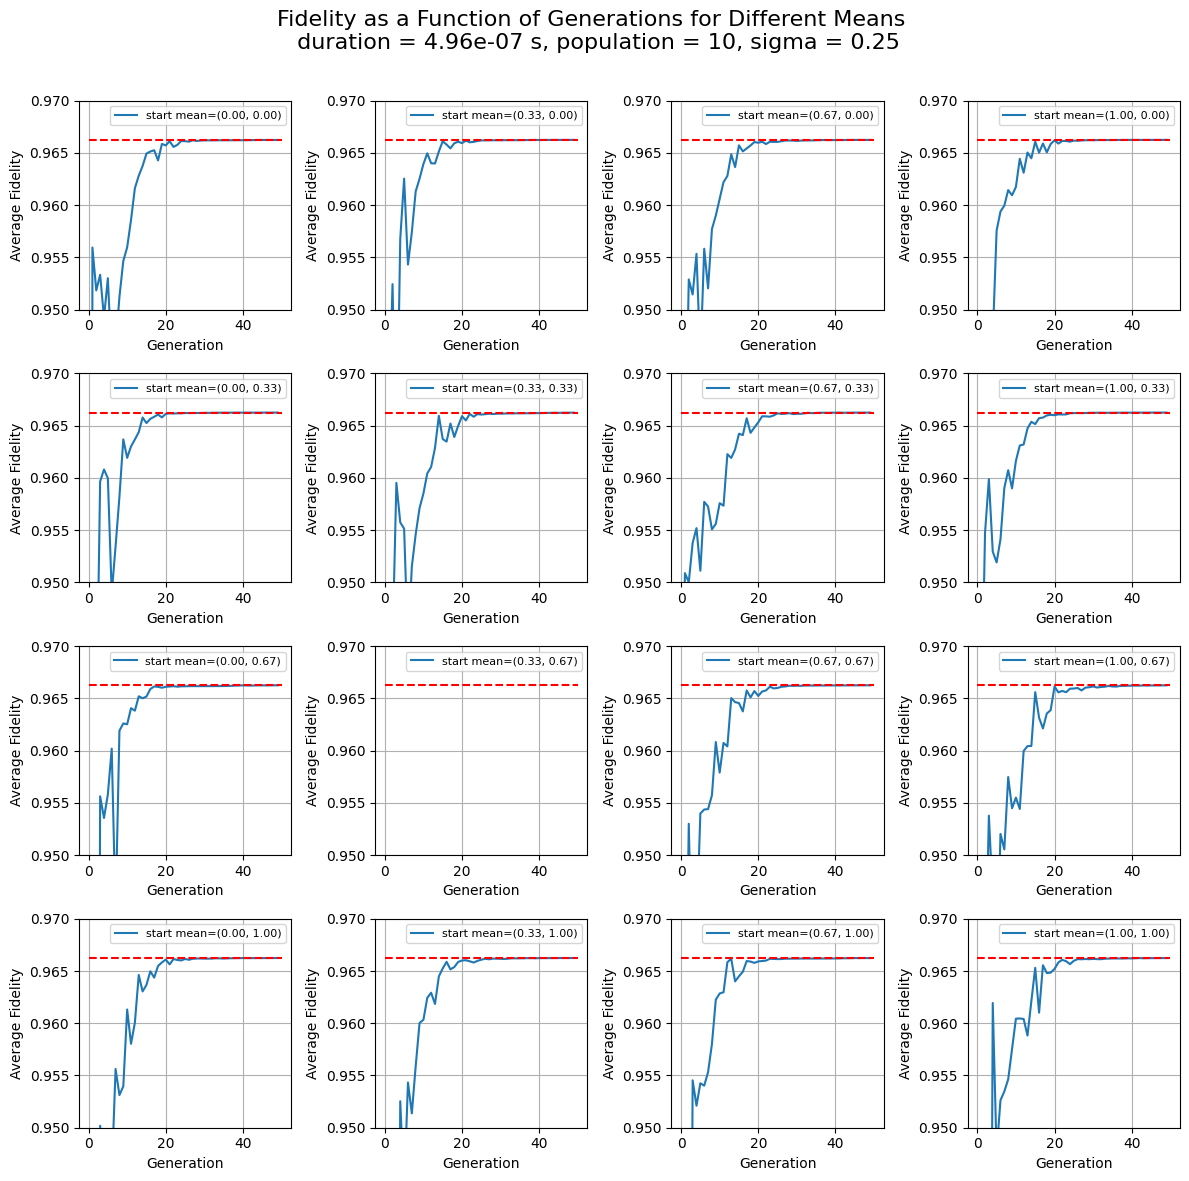

In [37]:
# Parameters
popsize = 10
sigma = 0.25  # 1/4 of the domain

boundX = [0, 1]
boundY = [0, 1]
bounds = np.array([boundX, boundY])

minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq - minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl - minAmpl

Ngen = 50

N_points = 4
# Grid for mean values
x = np.linspace(0, 1, N_points)
y = np.copy(x)
X, Y = np.meshgrid(x, y)

# Create subplots
fig, axes = plt.subplots(N_points, N_points, figsize=(12, 12))
fig.suptitle(f"Fidelity as a Function of Generations for Different Means \n duration = {duration:.3g} s, population = {popsize:.3g}, sigma = {sigma:.3g}", fontsize=16)

# Loop through each mean value
for i in range(len(x)):
    for j in range(len(y)):
        mean = np.array([X[i][j], Y[i][j]])
        
        # Initialize optimizer
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
        
        maxFidelity = np.zeros(Ngen)
        coordinate = np.zeros((Ngen, 2))
        meanFidelity = np.zeros(Ngen)
        
        # Optimization process
        for generation in range(Ngen):
            solutions = []
            fid = 0
            mean_hat = np.copy(optimizer.mean)
            mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
            mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl
        
            meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]
            for _ in range(optimizer.population_size):
                x = optimizer.ask()
                
                x_hat = np.copy(x)
                x_hat[0] = x_hat[0] * deltaFreq + minFreq
                x_hat[1] = x_hat[1] * deltaAmpl + minAmpl
                
                value = objective(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                tmpFidelity = fidelityEstimate(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                if tmpFidelity > fid:
                    maxFidelity[generation] = tmpFidelity[0]
                    coordinate[generation, :] = x_hat
                    fid = tmpFidelity
                
                solutions.append((x, value))
            
            optimizer.tell(solutions)
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        ax.plot(range(Ngen), meanFidelity, label=f"start mean=({mean[0]:.2f}, {mean[1]:.2f})")
        # ax.set_title(f"Mean=({mean[0]:.2f}, {mean[1]:.2f})", fontsize=10)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Average Fidelity")
        ax.set_ylim([0.95,0.97])
        # ax.set_yscale('log')
        ax.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--")
        ax.grid()
        ax.legend(fontsize=8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("Fidelity as a function of generatios - mean.pdf")
plt.show()

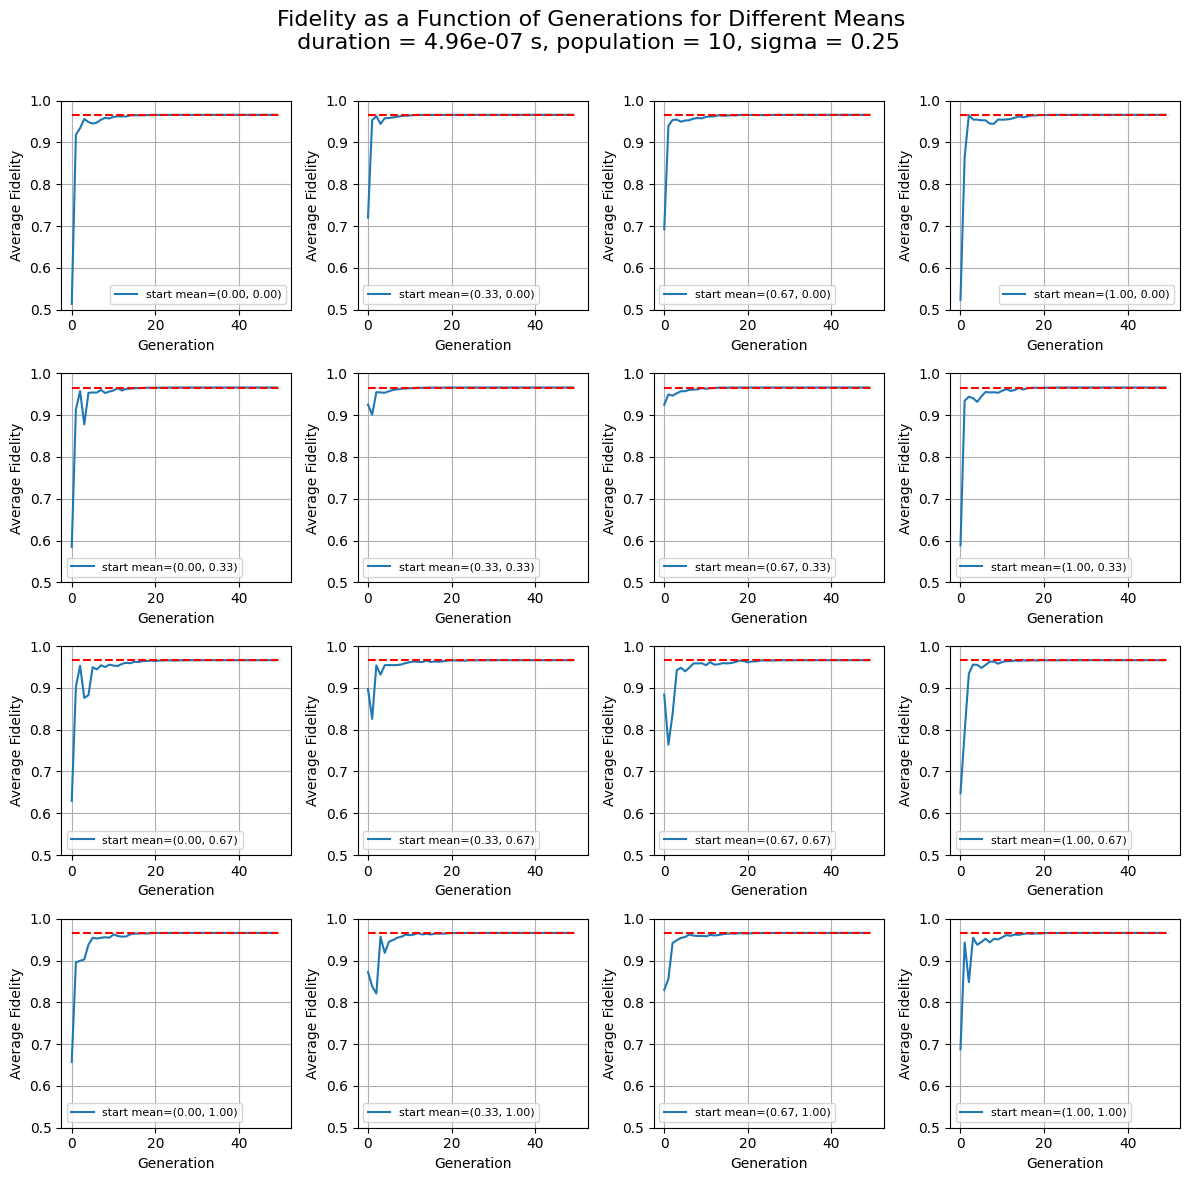

In [39]:
# Parameters
popsize = 10
sigma = 0.25  # 1/4 of the domain

boundX = [0, 1]
boundY = [0, 1]
bounds = np.array([boundX, boundY])

minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq - minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl - minAmpl

Ngen = 50

N_points = 4
# Grid for mean values
x = np.linspace(0, 1, N_points)
y = np.copy(x)
X, Y = np.meshgrid(x, y)

# Create subplots
fig, axes = plt.subplots(N_points, N_points, figsize=(12, 12))
fig.suptitle(f"Fidelity as a Function of Generations for Different Means \n duration = {duration:.3g} s, population = {popsize:.3g}, sigma = {sigma:.3g}", fontsize=16)

# Loop through each mean value
for i in range(len(x)):
    for j in range(len(y)):
        mean = np.array([X[i][j], Y[i][j]])
        
        # Initialize optimizer
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize, bounds=bounds)
        
        maxFidelity = np.zeros(Ngen)
        coordinate = np.zeros((Ngen, 2))
        meanFidelity = np.zeros(Ngen)
        
        # Optimization process
        for generation in range(Ngen):
            solutions = []
            fid = 0
            mean_hat = np.copy(optimizer.mean)
            mean_hat[0] = mean_hat[0]*deltaFreq+minFreq
            mean_hat[1] = mean_hat[1]*deltaAmpl+minAmpl
        
            meanFidelity[generation] = fidelityEstimate(mean_hat,frequency_test,amplitude_test,average_fidelity_test)[0]
            for _ in range(optimizer.population_size):
                x = optimizer.ask()
                
                x_hat = np.copy(x)
                x_hat[0] = x_hat[0] * deltaFreq + minFreq
                x_hat[1] = x_hat[1] * deltaAmpl + minAmpl
                
                value = objective(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                tmpFidelity = fidelityEstimate(x_hat, frequency_test, amplitude_test, average_fidelity_test)
                
                if tmpFidelity > fid:
                    maxFidelity[generation] = tmpFidelity[0]
                    coordinate[generation, :] = x_hat
                    fid = tmpFidelity
                
                solutions.append((x, value))
            
            optimizer.tell(solutions)
        
        # Plot in the corresponding subplot
        ax = axes[i, j]
        ax.plot(range(Ngen), meanFidelity, label=f"start mean=({mean[0]:.2f}, {mean[1]:.2f})")
        # ax.set_title(f"Mean=({mean[0]:.2f}, {mean[1]:.2f})", fontsize=10)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Average Fidelity")
        ax.set_ylim([0.5,1])
        # ax.set_yscale('log')
        ax.hlines(max(average_fidelity_test),0,Ngen, color = 'red', ls = "--")
        ax.grid()
        ax.legend(fontsize=8)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("Fidelity as a function of generatios - mean 0.5 to 1.pdf")
plt.show()